In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/AI_Practical_Sessions_24_25/Project

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1ymYxj1ml58tZ_ePTchhoin5x_Zv8_KRt/AI_Practical_Sessions_24_25/Project


In [ ]:
!pip install pynrrd

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import nrrd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB3, EfficientNetB4
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from skimage.transform import resize
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Define paths to training and validation dataset
train_folder = "train_subjects"
val_folder = "val_subjects"

# Function to load images and labels
def load_data(folder):
    images, labels = [], []
    num_files = len([f for f in os.listdir(folder) if "image" in f])

    for i in range(num_files):
        image_path = os.path.join(folder, f"subject_{i}_image.npy")
        label_path = os.path.join(folder, f"subject_{i}_label.npy")

        image = np.load(image_path)
        label = np.load(label_path)

        images.append(image)
        labels.append(label)

    return np.array(images), np.array(labels)

# Load training and validation data
X_train, y_train = load_data(train_folder)
X_val, y_val = load_data(val_folder)

print(f"Training Data: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation Data: {X_val.shape}, Labels: {y_val.shape}")

Training Data: (1890, 300, 300, 3), Labels: (1890,)
Validation Data: (473, 300, 300, 3), Labels: (473,)


In [ ]:
# Load EfficientNetB0 model without the classification head
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(300, 300, 3))
feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Extract features from training and validation sets
X_train_features = feature_extractor.predict(X_train, batch_size=32, verbose=1)
X_val_features = feature_extractor.predict(X_val, batch_size=32, verbose=1)

print(f"Extracted Training Features: {X_train_features.shape}")
print(f"Extracted Validation Features: {X_val_features.shape}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 23s 194ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 554ms/step
Extracted Training Features: (1890, 1280)
Extracted Validation Features: (473, 1280)


In [ ]:
# Apply SMOTE to balance only the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_features, y_train)

print(f"After SMOTE: X_train_smote = {X_train_smote.shape}, y_train_smote = {y_train_smote.shape}")

After SMOTE: X_train_smote = (2868, 1280), y_train_smote = (2868,)


## 1st attempt (plain)

In [ ]:
# Train an XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    objective='binary:logistic',
    random_state=42
)

xgb_model.fit(X_train_smote, y_train_smote)

# Evaluate on validation set
y_val_pred = xgb_model.predict(X_val_features)

print("Classification Report on Validation Set:")
print(classification_report(y_val, y_val_pred))

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       359
           1       0.27      0.30      0.28       114

    accuracy                           0.63       473
   macro avg       0.52      0.52      0.52       473
weighted avg       0.65      0.63      0.64       473



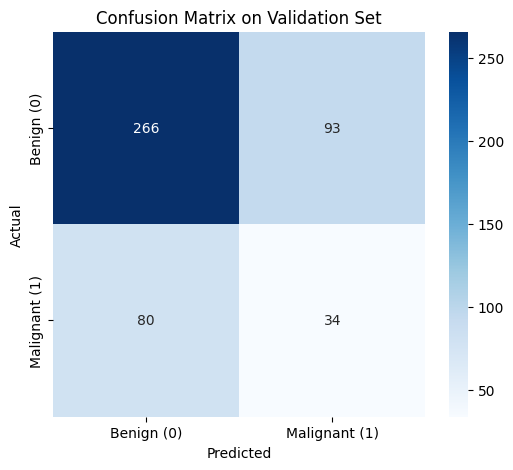

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign (0)", "Malignant (1)"],
            yticklabels=["Benign (0)", "Malignant (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Validation Set")
plt.show()

## 2nd attempt (using scale_pos_weight e.g. 2,3,4,5, which balances the loss by giving more weight to the minority class)

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.82      0.45      0.58       359
           1       0.28      0.68      0.40       114

    accuracy                           0.51       473
   macro avg       0.55      0.57      0.49       473
weighted avg       0.69      0.51      0.54       473



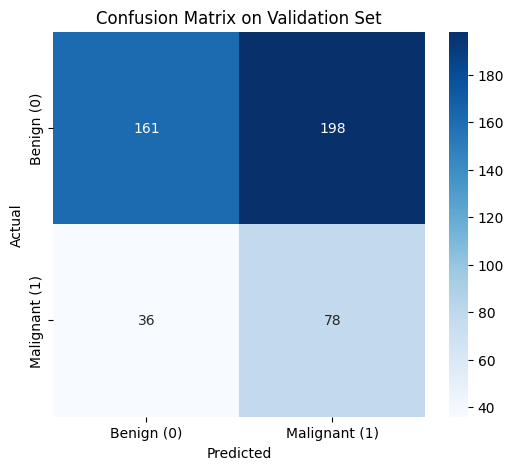

In [ ]:
# Train an XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    objective='binary:logistic',
    scale_pos_weight=4,  # Adjust weight for the minority class
    random_state=42
)

xgb_model.fit(X_train_smote, y_train_smote)

# Evaluate on validation set
y_val_pred = xgb_model.predict(X_val_features)

print("Classification Report on Validation Set:")
print(classification_report(y_val, y_val_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign (0)", "Malignant (1)"],
            yticklabels=["Benign (0)", "Malignant (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Validation Set")
plt.show()

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.81      0.49      0.61       359
           1       0.28      0.63      0.39       114

    accuracy                           0.52       473
   macro avg       0.54      0.56      0.50       473
weighted avg       0.68      0.52      0.56       473



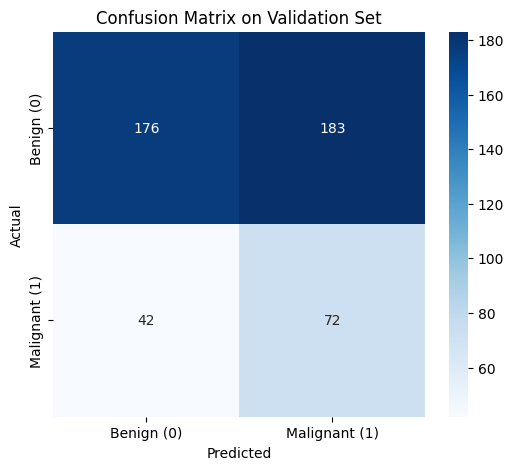

In [ ]:
# Train an XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    objective='binary:logistic',
    scale_pos_weight=3,  # Adjust weight for the minority class
    random_state=42
)

xgb_model.fit(X_train_smote, y_train_smote)

# Evaluate on validation set
y_val_pred = xgb_model.predict(X_val_features)

print("Classification Report on Validation Set:")
print(classification_report(y_val, y_val_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign (0)", "Malignant (1)"],
            yticklabels=["Benign (0)", "Malignant (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Validation Set")
plt.show()

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.81      0.58      0.68       359
           1       0.30      0.57      0.39       114

    accuracy                           0.58       473
   macro avg       0.56      0.57      0.53       473
weighted avg       0.69      0.58      0.61       473



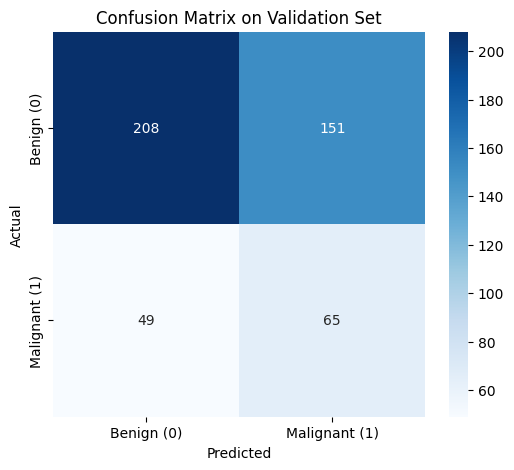

In [ ]:
# Train an XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    objective='binary:logistic',
    scale_pos_weight=2,  # Adjust weight for the minority class
    random_state=42
)

xgb_model.fit(X_train_smote, y_train_smote)

# Evaluate on validation set
y_val_pred = xgb_model.predict(X_val_features)

print("Classification Report on Validation Set:")
print(classification_report(y_val, y_val_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign (0)", "Malignant (1)"],
            yticklabels=["Benign (0)", "Malignant (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Validation Set")
plt.show()

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.84      0.46      0.59       359
           1       0.30      0.73      0.42       114

    accuracy                           0.52       473
   macro avg       0.57      0.59      0.51       473
weighted avg       0.71      0.52      0.55       473



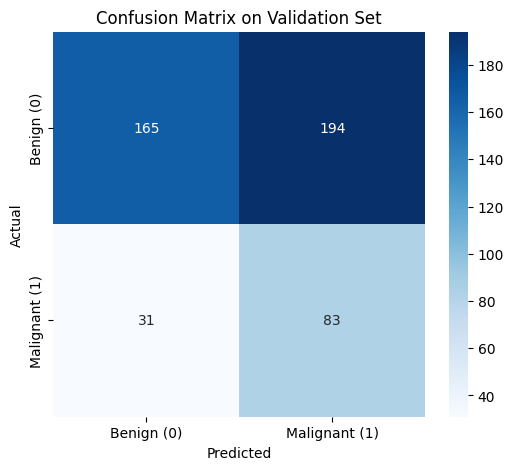

In [ ]:
# Train an XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    objective='binary:logistic',
    scale_pos_weight=5,  # Adjust weight for the minority class
    random_state=42
)

xgb_model.fit(X_train_smote, y_train_smote)

# Evaluate on validation set
y_val_pred = xgb_model.predict(X_val_features)

print("Classification Report on Validation Set:")
print(classification_report(y_val, y_val_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign (0)", "Malignant (1)"],
            yticklabels=["Benign (0)", "Malignant (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Validation Set")
plt.show()

Key Observations for comparing 4 and 5 (as scale_pos_weight) ->
Class 1 (Malignant) Improvement:
Precision, recall, and F1-score for malignant cases improved slightly in the second approach (scale_pos_weight=5).
Recall for malignant cases increased from 68% to 73%, which is crucial since detecting malignant cases is often more important in medical applications.
Class 0 (Benign) Performance:
Precision, recall, and F1-score for benign cases also improved slightly, showing that increasing scale_pos_weight did not negatively affect this class.
Overall Accuracy:
The accuracy increased slightly (51% → 52%) in the second approach, indicating better overall classification.

## 3rd attempt; Feature Engineering and Selection (using Feature Importance derived from XGBoost -> selecting 50 or 100 top important features))

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.83      0.33      0.48       359
           1       0.27      0.78      0.40       114

    accuracy                           0.44       473
   macro avg       0.55      0.56      0.44       473
weighted avg       0.69      0.44      0.46       473



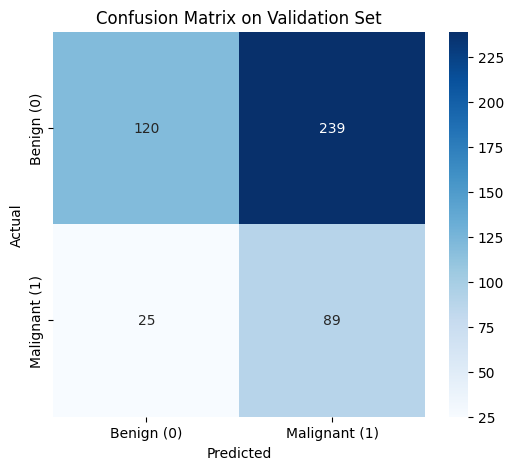

In [ ]:
# Get feature importance and select top-k features
importance = xgb_model.feature_importances_
top_k_features = np.argsort(importance)[-50:]  # Select top 50 features
X_train_selected = X_train_smote[:, top_k_features]
X_val_selected = X_val_features[:, top_k_features]

# Train XGBoost with selected features
xgb_model.fit(X_train_selected, y_train_smote)

# Predict on the validation set with selected features
y_val_pred = xgb_model.predict(X_val_selected)

# Print classification report
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_val_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign (0)", "Malignant (1)"],
            yticklabels=["Benign (0)", "Malignant (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Validation Set")
plt.show()

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.80      0.36      0.50       359
           1       0.26      0.72      0.39       114

    accuracy                           0.45       473
   macro avg       0.53      0.54      0.44       473
weighted avg       0.67      0.45      0.47       473



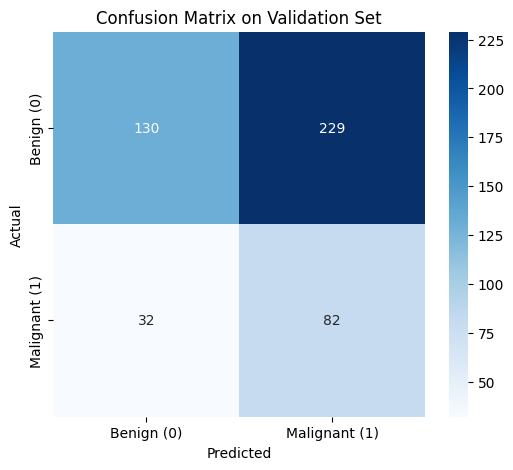

In [ ]:
# Get feature importance and select top-k features
importance = xgb_model.feature_importances_
top_k_features = np.argsort(importance)[-100:]  # Select top 100 features
X_train_selected = X_train_smote[:, top_k_features]
X_val_selected = X_val_features[:, top_k_features]

# Train XGBoost with selected features
xgb_model.fit(X_train_selected, y_train_smote)

# Predict on the validation set with selected features
y_val_pred = xgb_model.predict(X_val_selected)

# Print classification report
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_val_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign (0)", "Malignant (1)"],
            yticklabels=["Benign (0)", "Malignant (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Validation Set")
plt.show()

## 4th attempt; Feature Engineering and Selection (using PCA with 95% and 99% cumulative explained variance)

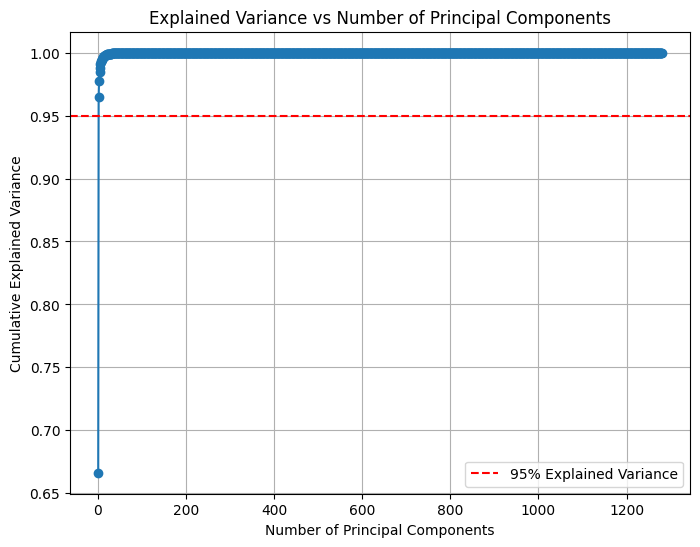

Number of components to retain 95% variance: 2


In [ ]:
from sklearn.decomposition import PCA
# Fit PCA to the training data
pca = PCA()
X_train_pca = pca.fit_transform(X_train_smote)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs Number of Principal Components")
plt.legend()
plt.grid()
plt.show()

# Select the number of components to retain 95% variance
n_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components to retain 95% variance: {n_components}")

# Reduce the dimensionality of the datasets
pca = PCA(n_components=n_components)
X_train_reduced = pca.fit_transform(X_train_smote)
X_val_reduced = pca.transform(X_val_features)

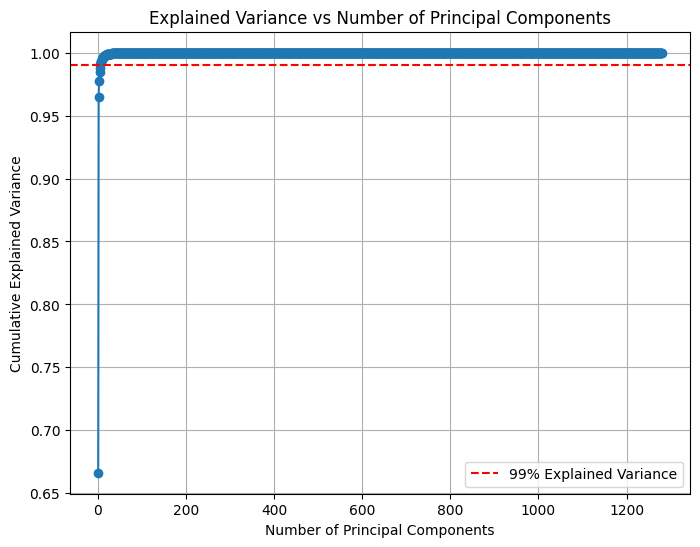

Number of components to retain 99% variance: 6


In [ ]:
from sklearn.decomposition import PCA
# Fit PCA to the training data
pca = PCA()
X_train_pca = pca.fit_transform(X_train_smote)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(y=0.99, color='r', linestyle='--', label='99% Explained Variance')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs Number of Principal Components")
plt.legend()
plt.grid()
plt.show()

# Select the number of components to retain 99% variance
n_components = np.argmax(cumulative_variance >= 0.99) + 1
print(f"Number of components to retain 99% variance: {n_components}")

# Reduce the dimensionality of the datasets
pca = PCA(n_components=n_components)
X_train_reduced = pca.fit_transform(X_train_smote)
X_val_reduced = pca.transform(X_val_features)

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.83      0.19      0.31       359
           1       0.26      0.88      0.40       114

    accuracy                           0.36       473
   macro avg       0.54      0.53      0.35       473
weighted avg       0.69      0.36      0.33       473



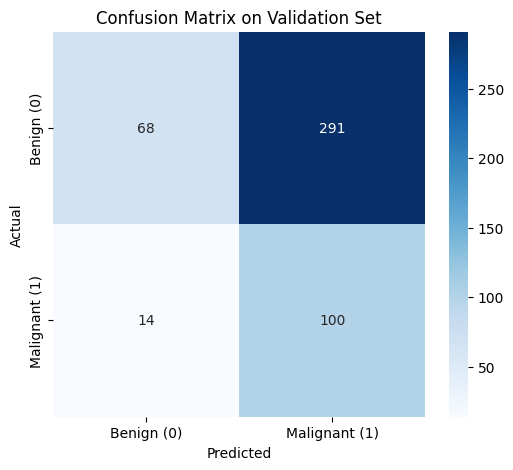

In [ ]:
# Train XGBoost with reduced features
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    objective='binary:logistic',
    scale_pos_weight=5,
    random_state=42
)

xgb_model.fit(X_train_reduced, y_train_smote)

# Evaluate on validation set
y_val_pred = xgb_model.predict(X_val_reduced)

# Print classification report
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_val_pred))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Benign (0)", "Malignant (1)"],
            yticklabels=["Benign (0)", "Malignant (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Validation Set")
plt.show()